# Package Installation

In [1]:
options(repr.plot.width=20, repr.plot.height=10, warn=1)
install.packages('pacman')

pacman::p_load(readxl, fastGHQuad, stats4)

library(readxl)
library(fastGHQuad)
library(stats4)
library(pracma)
library(rootSolve)

Installing package into 'C:/Users/kenri/Documents/R/win-library/4.1'
(as 'lib' is unspecified)



package 'pacman' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\kenri\AppData\Local\Temp\RtmpQJvatO\downloaded_packages


Warning message:
"package 'pracma' was built under R version 4.1.3"
Warning message:
"package 'rootSolve' was built under R version 4.1.1"

Attaching package: 'rootSolve'


The following objects are masked from 'package:pracma':

    gradient, hessian




# Cointegrated Pair

The spread of two cointegrated assets is the solution to the following stochastic differential equation

$ dU_t = -\mu  U_tdt + \sigma dW_t + dN_t $

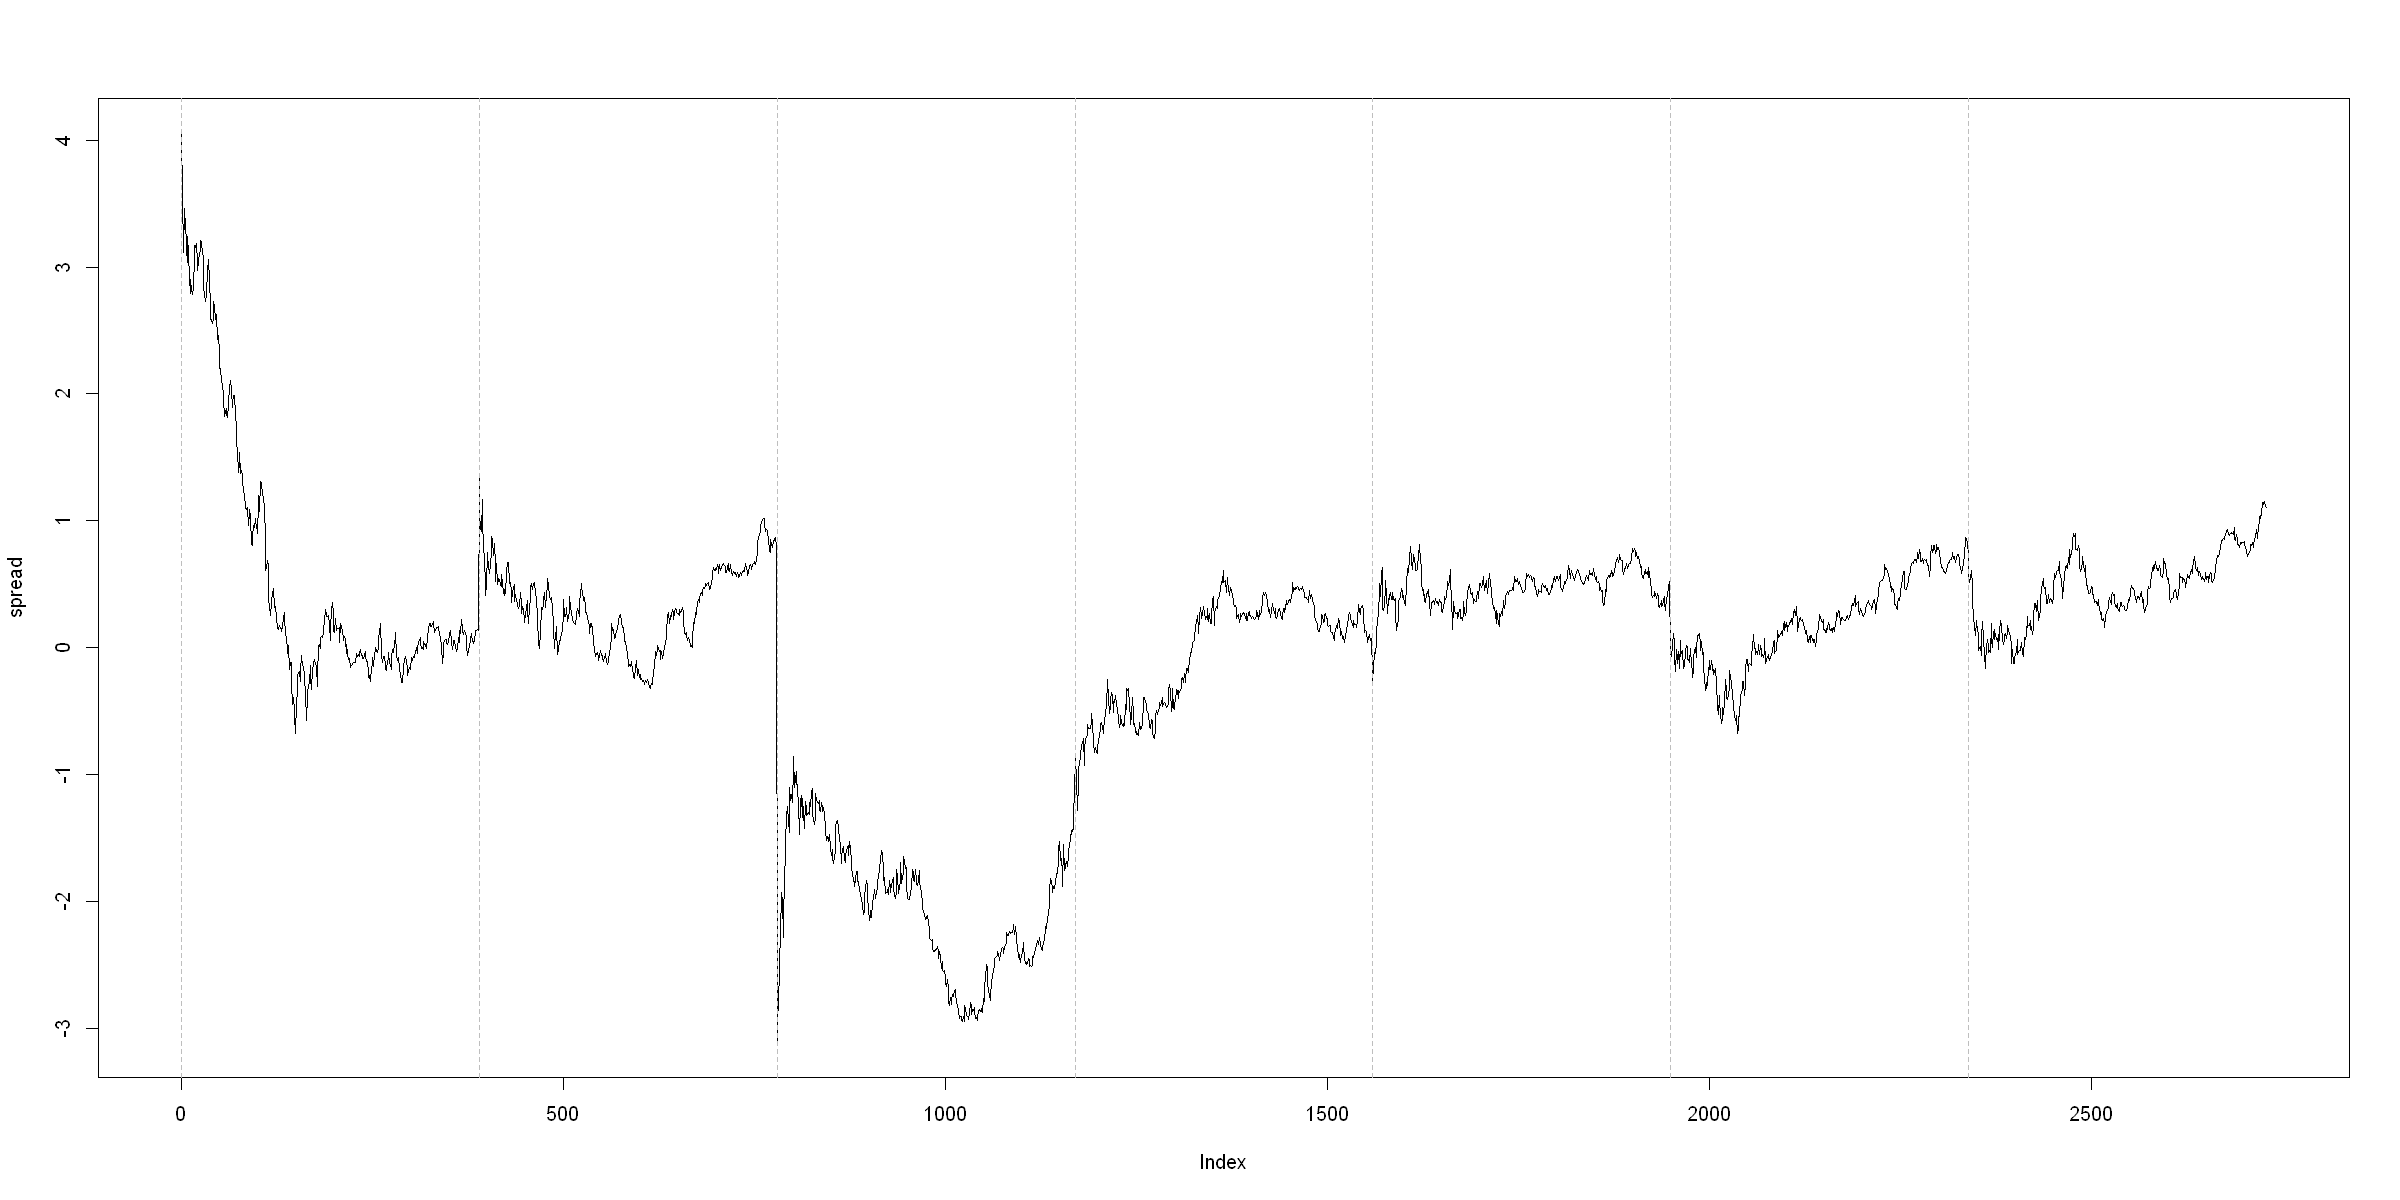

In [2]:
df = read_excel("cointegratedSpreadAMDNVDA.xlsx")
spread = df[, 2][[1]]
plot(spread, type='l')

# Vertical lines indicate days
vline = as.numeric(seq(0, length(spread), by = 390))
abline(v = vline, col='gray', lty=2)

# Jump Detection & Estimation

We apply the method in Fonseca & Ignatieva (2019) for daily jump detection. 

Let $r_{t,i} = y_{t, i\Delta} - y_{t, (i-1)\Delta}$. 

We consider the RV for each day, which has 390 observations.

In [3]:
m = 390
delta = 1 / m
noObs = ceiling(seq_along(spread)/m)

# Split the dataset per m observations
spreadInterval = split(spread, noObs)

rtInterval = array()
noInterval = length(spreadInterval)

# Calculates for the differenced series rtInterval
for (i in 1: noInterval) {

    rtInterval[i] = list(diff(spreadInterval[[i]]))
}

The realized variance (RV) is given by

##### $ RV = \sum_{i=1}^m r_{t,i}^2 $, 

In [4]:
# This type of loop will be used repeatedly throughout the code.
realizedVarInterval = array()

# Calculates RV
for (i in 1: noInterval) {

    # Resets the productTemp array for each subset    
    productTemp = array()

    # Iterates over each observation in rtInterval to get the sum (incase the number of observations are not the same everyday)
    for (k in 1: length(rtInterval[[i]])) {

        productTemp[k] =  ( rtInterval[[i]][k] )^2
    }

    realizedVarInterval[i] = sum(na.omit(productTemp))
}

realizedVarInterval = na.omit(realizedVarInterval)

The realized bipower variation (BV) is given by

##### $BV = \frac{\pi}{2} \frac{m}{m-1} \sum_{i=2}^m |r_{t,i}| |r_{t,i-1}| $

In [5]:
sumInterval = array()
bipowerVarInterval = array()

# Calculates BV
for (i in 1: noInterval) {
  
    productTemp = array()

    for (k in 2: length(rtInterval[[i]])) {

        productTemp[k] =  abs(rtInterval[[i]][k]) * abs(rtInterval[[i]][k-1]) 
    }

    sumInterval[i] = sum(na.omit(productTemp))
    bipowerVarInterval[i] = (pi / 2) * m / (m-1) * sumInterval[[i]]
}

bipowerVarInterval = na.omit(bipowerVarInterval)

Next, we calculate the magnitude of the jumps. The test statistic is given by 
##### $RJ = \frac{RV-BV}{RV}$

In [6]:
RJV = realizedVarInterval - bipowerVarInterval
RJ = RJV / realizedVarInterval

Let TP be the tripower quarticity that is robust to jumps, 

##### $\mu_{4/3} = 2^{2/3} \frac{\Gamma( (7/6)))}{\Gamma(1/2)} $

##### $TP = m \mu_{4/3}^{-3} \frac{m}{m-2} \sum_{t=3}^m |r_{t, i-2}|^{4/3} |r_{t, i-1}|^{4/3} |r_{t,i}|^{4/3} $

In [7]:
tripowerInterval = array()
mu = (2^(2/3)) * gamma(7/6) / gamma(1/2)

# Calculates TP
for (i in 1:  length(rtInterval)) {
    
    productTemp = array()

    for (k in 3: length(rtInterval[[i]])) {

        productTemp[k] = abs(rtInterval[[i]][k-2])^(4/3) * abs(rtInterval[[i]][k-1])^(4/3) * abs(rtInterval[[i]][k])^(4/3)
    }

    sumInterval[i] = sum(na.omit(productTemp))
    tripowerInterval[i] = m * (mu)^(-3) * m / (m-2) * sumInterval[[i]]
}

The test statistic converges in distribution to a Gaussian distribution when we use the scaling:

 ##### $ZJ_t = \frac{RJ_t}{\sqrt{ [ (\frac{\pi}{2})^2 + \pi -5] \Delta Max(1, \frac{TP_t}{BV_t^2}) } } $

In [8]:
ZJ = array()

# Calculates for ZJ
for (i in 1:length(RJ)) {
    
    ZJ[i] = RJ[i] / ( ( (pi/2)^2 + pi - 5) * delta * max(1, tripowerInterval[i]/bipowerVarInterval[i]) )^(1/2)
}

The magnitude of the jump Jt is given by

##### $J_t = sign(r_t) \times \sqrt{ (RV- BV) \times I_{ZJ \ge \Phi_\alpha^{-1}} }$

since $r_{t,i} = y_{t,i\Delta} - y_{t, (i-1)\Delta} $, I assume that $r_t = y_t - y_{t-1} $,  where $y_t = dailyreturn_{t} - dailyreturn_{t-1} $  

In [9]:
# Computes for the sign of rt
retCurrent = array()
retPrevious = array()
ret = array()

# for interval 1 we take sign(rt) = sign[ day one's (spread_10 - spread_1) ]
intervalOne = sign( spreadInterval[[1]][length(spreadInterval[[1]])] - spreadInterval[[1]][1] )
ocSpread = array(intervalOne) 

# Computes for the spread as the difference between the the second interval's start price and the previous interval's ending price
for (i in 2: noInterval) {

    # calculate the return on day t (y_t)
    retCurrent[i] =  spreadInterval[[i]][length(spreadInterval[[i]])] - spreadInterval[[i]][1]
    retPrevious[i] = spreadInterval[[i-1]][length(spreadInterval[[i-1]])] - spreadInterval[[i-1]][1]
    ret[i] = retCurrent[i] - retPrevious[i]

    rt = append(ocSpread, ret)
}

sign = sign(na.omit(rt))

In [10]:
# This is a Monte Carlo method to calculate the area under the inverse normal cumulative distribution function. 
alpha = 0.90
x = rnorm(100000, 0, 1)
pdf = density(x)

# Interpolate the density
f = approxfun(pdf$x, pdf$y, yleft=0, yright=0)

# Get the cdf by numeric integration
cdf = function(x){

  integrate(f, -Inf, x)$value
}

# Use a root finding function to invert the cdf
invcdf = function(q){

  uniroot(function(x){cdf(x) - q}, range(x))$root
}

threshold = as.numeric(invcdf(alpha))

# Let ZJ be the indicator function, we replace non-statistically significant values with zero.
for (i in 1:  length(ZJ)) {
    
    if (ZJ[i] > threshold) {

        ZJ[i] = 1
    }

    else {
        ZJ[i] = 0
    }
}

JT = sign * ( RJV * ZJ )^(1/2)

# Removing the Jumps from the process

We assume that if a jump was detected on day t, then the jump occured in between the close price of interval t-1 and the open price of interval t. Thus, the jump affected the opening price of interval t

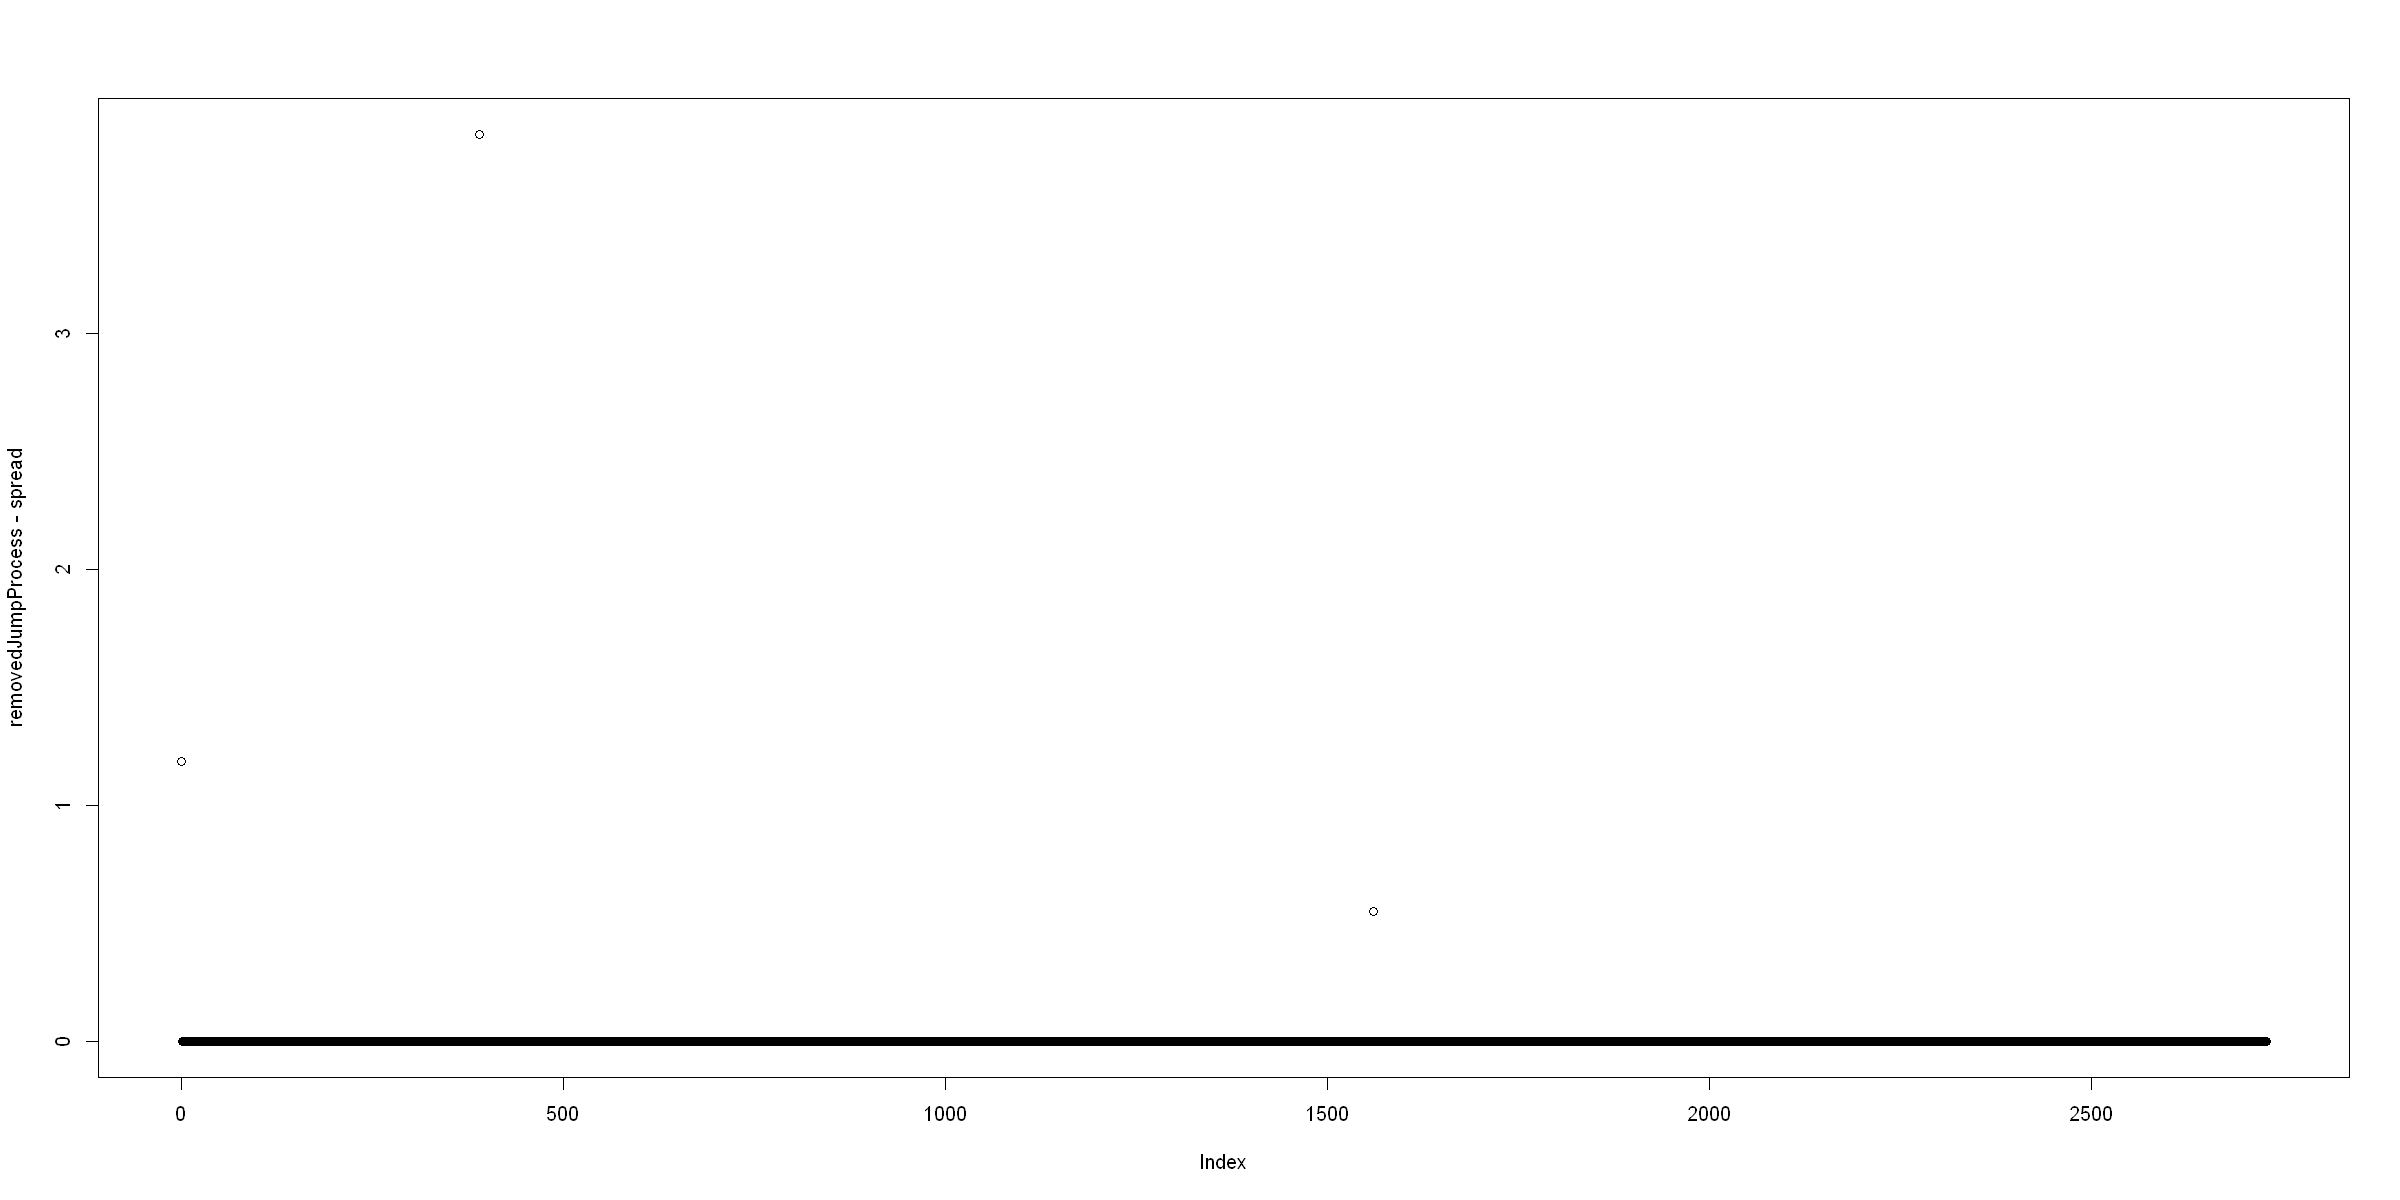

In [11]:
# Remove the jumps by subtracting the magnitude of the jump to the first price at interval t
jumpInterval = which(JT!=0, arr.ind = T)

# Replaces the price with (price - jump) on jumpInterval
for (i in 1:  length(spreadInterval)) {
    
    if (i %in% jumpInterval) {
        spreadInterval[[i]] = replace(spreadInterval[[i]], 1, spreadInterval[[i]][1] - JT[i])
    }
}

# The frequency lambda is given by the number of days where a jump occurs divided by the total number of days
lambda = length(jumpInterval) / noInterval

# Let k be the size of the jumps
k = mean(JT)

removedJumpProcess = unlist(spreadInterval)
plot(removedJumpProcess - spread)

# Estimation of Parameters

Now that we have removed the jumps, we have a standard diffusion process of the form

##### $ dU_t = -\mu U_tdt + \sigma dW_t $

In [12]:
checkOU <- function(theta){
  if(theta[1]<=0) message("\nthe process is not stationary\n")
  if(theta[2]<=0) stop("variance must be positive")
}

mydsOU <- function(x, theta, log = FALSE){
  checkOU(theta)
  dnorm(x, mean=0, sd=theta[2]/sqrt(2*theta[1]), log=log)
}

 ou.lik = function(x) {

  function(theta1, theta2) {
    
    n = length(x)
    dt = deltat(x)

    -sum(mydsOU(x = x[2:n],
      theta = c(theta1, theta2), log=TRUE))
  }
}

ou.fit = mle(ou.lik(spread),
          start = list(theta1 = 0.2, theta2 = 0.7),
          method="L-BFGS-B")
  
ou.coe = coef(ou.fit)
ou.coe

mu = ou.coe[[1]]
sigma = ou.coe[[2]]

theta1    theta2 
0.2333482 0.6812268

# Numerical Solution

Our Goal is to find $\beta$ and $v(x_i)$ by solving the free-boundary problem

$ L v = f, \quad  x \in (\alpha, \beta) $

$ v(x) = 0, \quad x \notin (\alpha, \beta) $

where $f(x) = - \mu x$ and then fix $\alpha < 0$ to find $\beta > \alpha$ such that $v'(\beta) = 0$

Our approach is to solve the linear complementarity problem given by

$ (L v-f)(v- \phi) = 0, $

$L v-f \ge 0, \quad v- \phi \ge 0, $

$ v(\alpha) = v(\beta) = 0 $

a.e. on $[\alpha, \beta)$ and with the condition

$ v(x) = \phi(x).$

In [13]:
# Discretization of the price
xmin = min(spread)
xmax = max(spread)
Nx = 780
dx = (xmax - xmin)/Nx
x = spread
f = - mu * x

# Evaluates if alpha had been hit during the process and cuts the spread until the first hitting time of alpha
alpha = -4
alphaSpread = spread

alphaSpread[alphaSpread < alpha] = 0
alphaIndex = which(alphaSpread == 0)[1]
# if alphaIndex returns NA, we set the value to zero.
alphaIndex[ is.na(alphaIndex) ] = 0

if (alphaIndex != 0) {
    
    plot(spread, type='l', main="Alpha Hitting Time")
    abline(v = alphaIndex)

    spread = spread[1:alphaIndex]
    alpha = spread[alphaIndex][1]
}

We apply the finite differences method defined below for non-jump components

$  v'(x_i) \approx \dfrac{v(x_{i}) - v(x_{i-1})}{\Delta x}  $


$ v''(x_i) \approx \dfrac{v(x_{i+1}) - 2v(x_i) + v(x_{i-1})}{(\Delta x)^2} $

In [14]:
sigma2 = sigma^2
dx2 = dx^2
A = matrix(0, nrow=length(spread), ncol=length(spread))

for (i in 1: length(spread)-1){
    a = -mu * x[i] / dx - 1/2 * sigma2 / dx2 # -1 diagonal
    c = -1/2 * sigma2 / dx2 # +1 diagonal

    A[i,i+1] = c
    A[i+1,i] = a
}

b = mu * x / dx + sigma2 / dx2 # main diagonal

# The array concatenation is for the case when alpha is hit
diag(A) = b[1:length(spread)]

To solve the integral term $\int_{-\infty}^{\infty}[v(x+y)-v(x))] \varphi(y) d y$, we apply Gauss-Hermite Quadrature and approximate using the following

$ \int_{-\infty}^\infty v(x_i)\varphi(y) d y \approx \sum_{j=1}^L w_j v(x_i) $

$ \int_{-\infty}^\infty v(x_i+y)\varphi(y)d y  \approx \sum_{j=1}^L w_j v(x_i + y_j) $

In [15]:
# Define the Integral Solver Function
# Set 3000 nodes for gauss-hermite quadrature
rule = gaussHermiteData(3000)
jumpIndex = which(removedJumpProcess[1:length(spread)] - spread != 0)

integralSolve = function(previousV) {

    # Used to generate v(x_i) in quadrature
    sequenceX = seq(previousV)

    # Used to generate v(x_i + y_j) in quadrature
    sequenceXPlusY = seq(previousV)

    # Calculates (x+y) where y_i is the magnitude of the jump at index i
    for (i in 1:length(jumpIndex)) {
        
        sequenceXPlusY[jumpIndex[i]] = sequenceXPlusY[jumpIndex[i]] + JT[i]  
    }
    
    # interpolates a polynomial for v(x_i) and v(x_i + y_j)
    splinePoly = splinefun(sequenceX, previousV, method="fmm")
    splinePolyPlusy = splinefun(sequenceXPlusY, previousV, method="fmm")

    # Calculates the value of the integral from -inf to inf [ f(x) * e^{-x^2} ]
    vOfX = ghQuad(splinePoly, rule) 
    vOfXPlusY = ghQuad(splinePolyPlusy, rule)

    integral = vOfXPlusY - vOfX
    return(integral)
}

We set an initial value for $v^0(x_i)$ at the first iteration and iteratively solve the system $Av^k = f^k$, where $k$ denotes the k'th iteration until the error is sufficiently small. The integral term is incorporated in $f^k$.

In [16]:
# For iteration k = 0
epsilon = 0.1
threshold = 1e-5

# Initialize variables for sequence k=1 and solve for v^1(x)
initialIter = 0.5
vZero = array(initialIter, length(spread))

integral = integralSolve(vZero)
fk = f[1:length(spread)] + lambda * integral
newV = solve(A, fk)

# For iteration k >= 1
while (epsilon > threshold) {

    # Saves the oldV to be used in the calculation of epsilon
    oldV = newV
    integral = integralSolve(newV)
    fk = f[1:length(spread)] + lambda * integral

    # Solves the system Av^k = f^k
    newV = solve(A, fk)
    epsilon = max(newV - oldV)
}

v = newV

# plot(v, main = 'Graph of v', type = 'l')
# plot(diff(v), main = 'Graph of The First Derivative of v', type = 'l')

The terminal boundary condition is given by

$ v'(\beta) = 0 $,

[1] -0.5828034

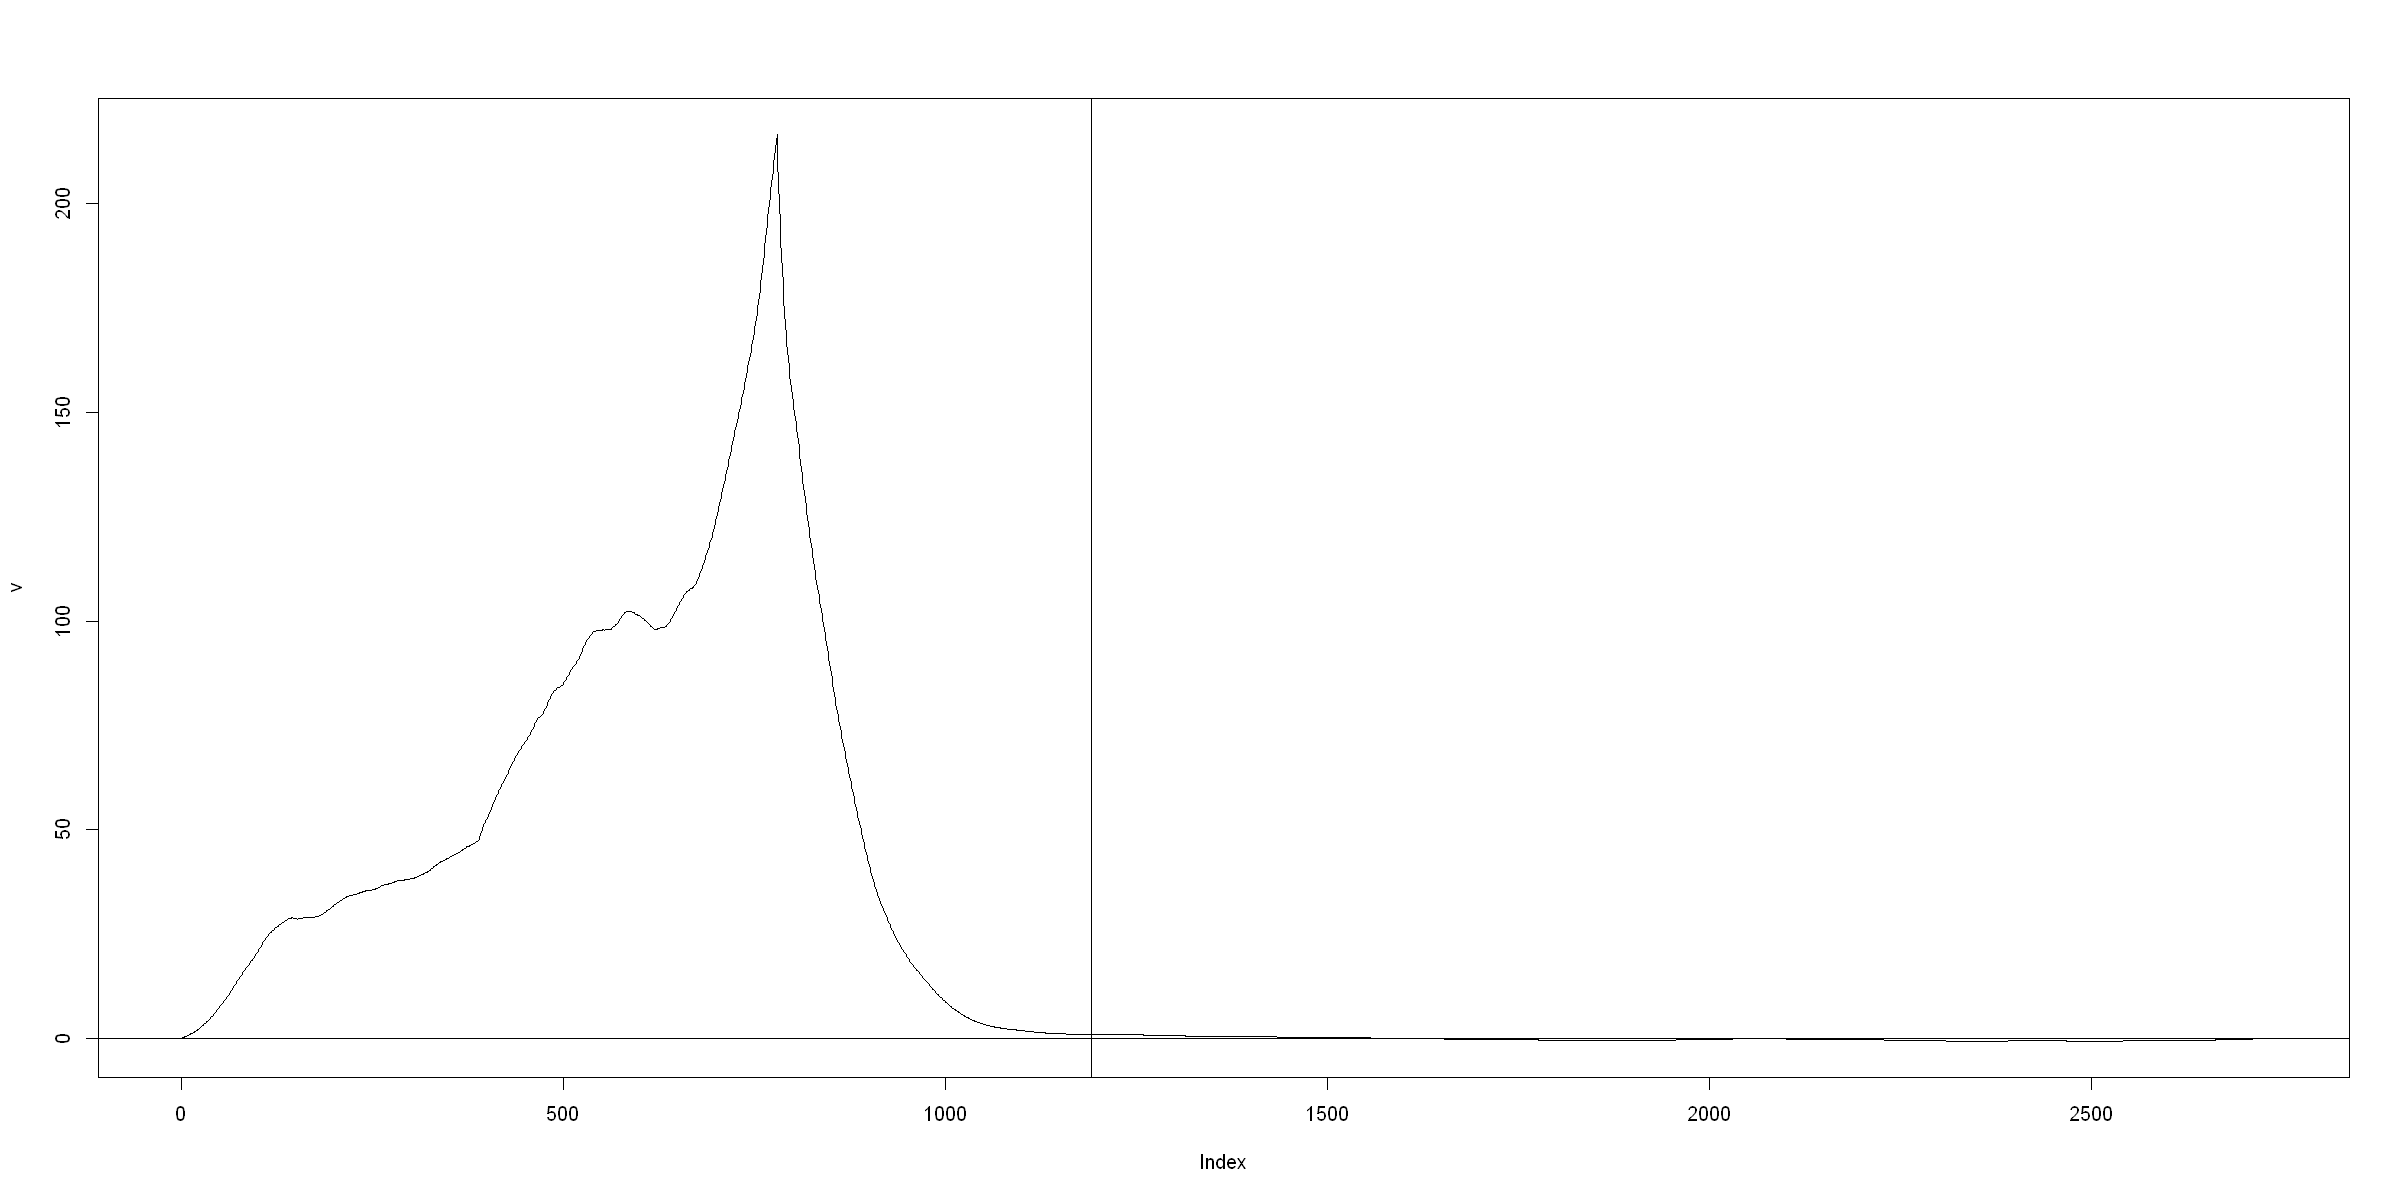

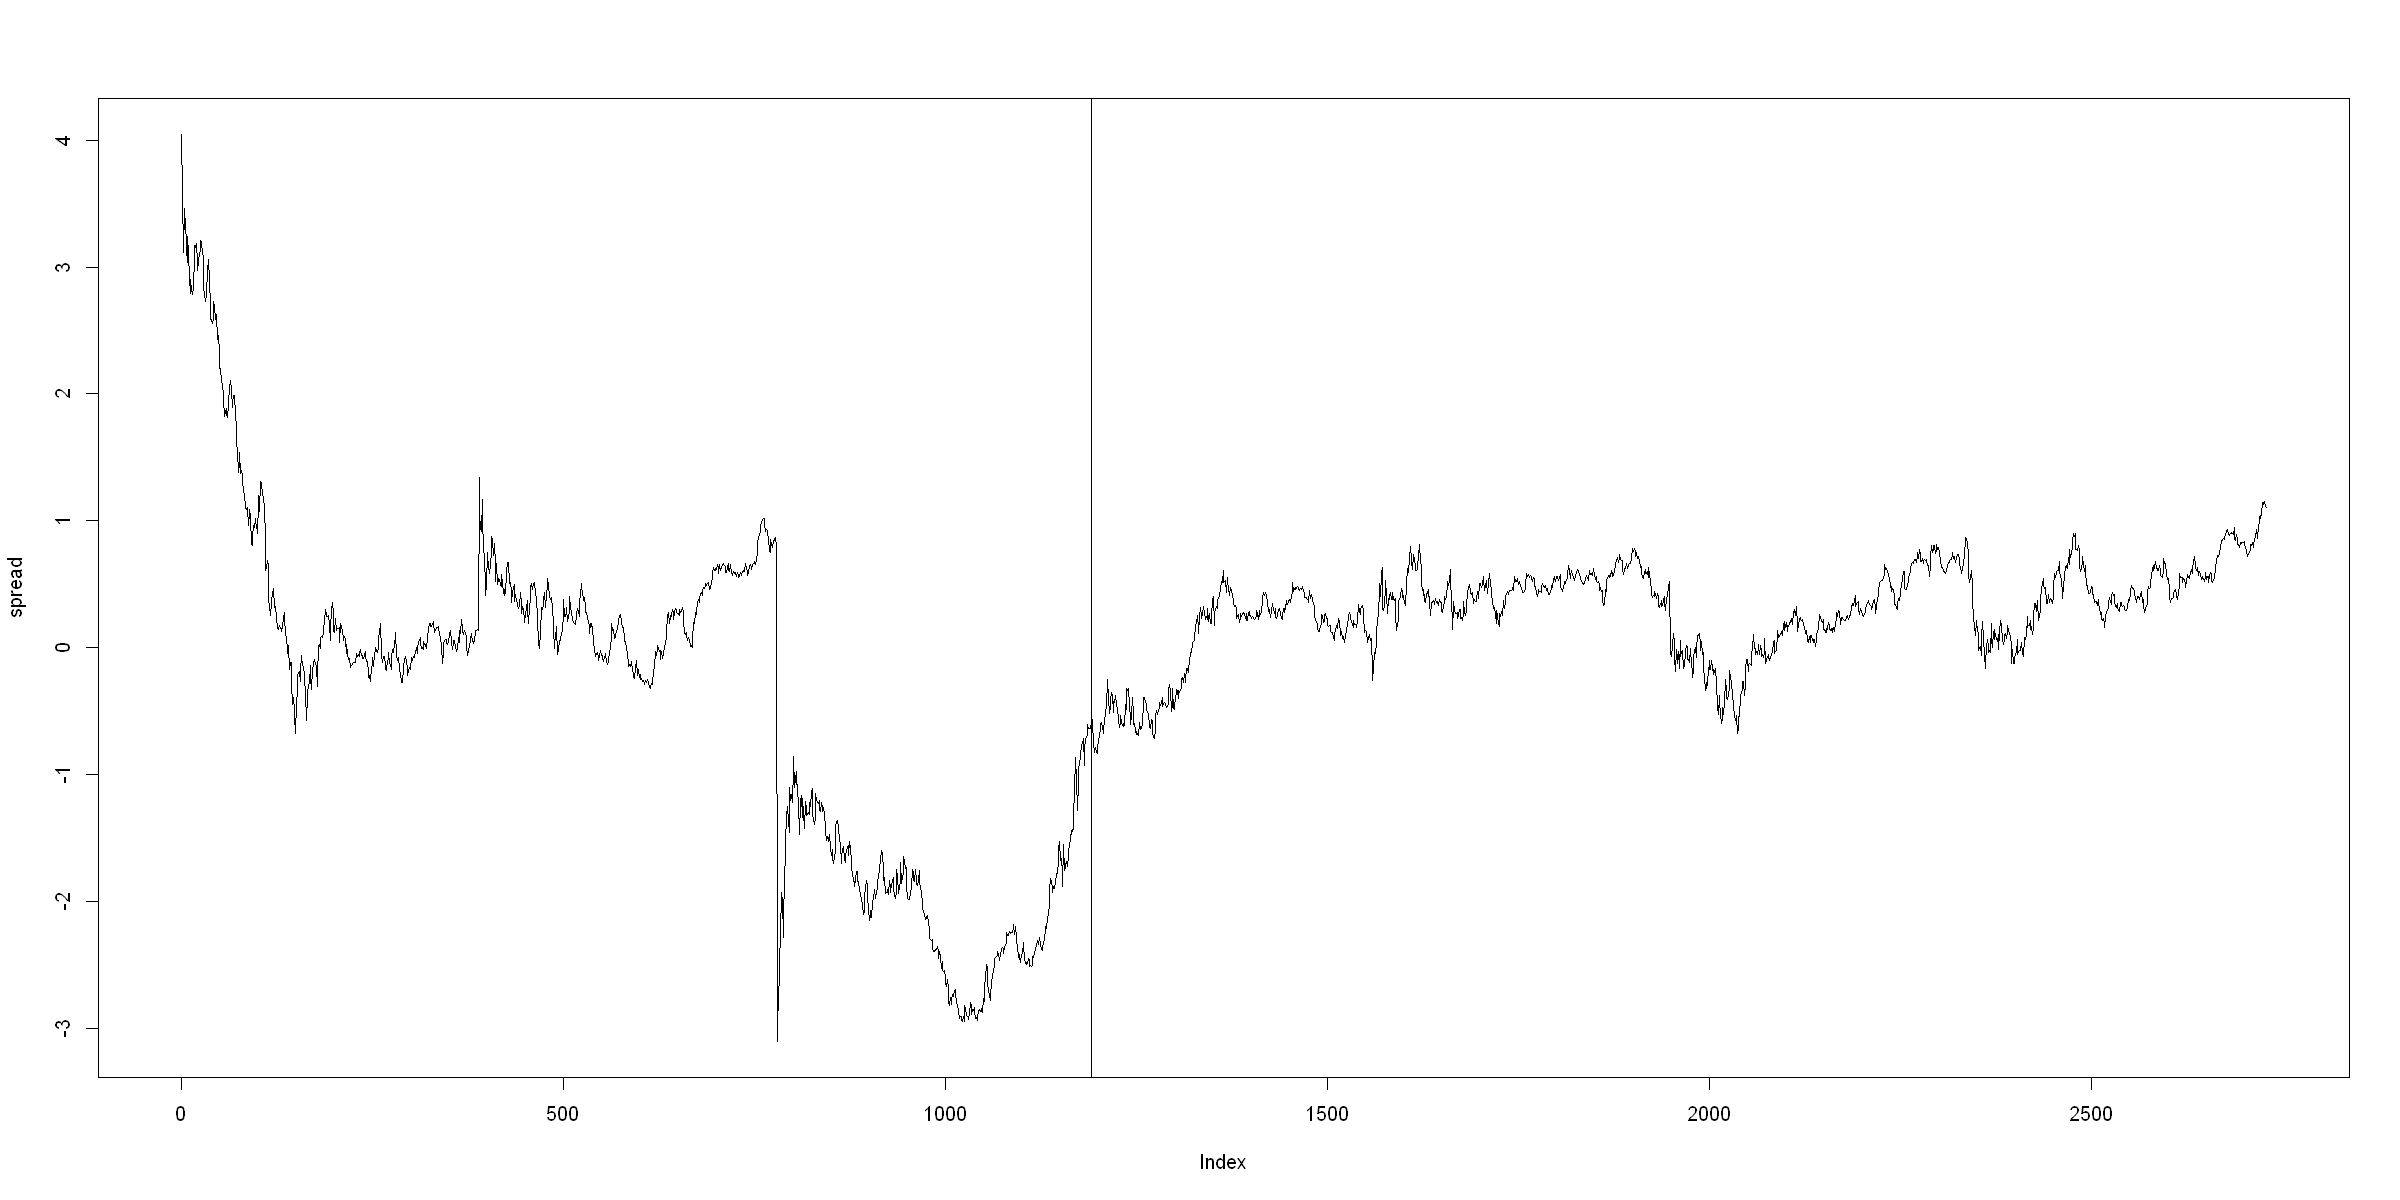

In [17]:
vPrime = diff(v)
# the turning point is the smallest number closest to zero
derivTurningPoint = which.min(abs(vPrime))

# We interpolate for 10 values around the turning point
derivLocalInterval = (derivTurningPoint-10):(derivTurningPoint+10)

# We cut vPrime to contain a list with the 10 values were interpolating around
derivLocal = vPrime[derivLocalInterval]

# To avoid multiple roots, we cut the local series to only cross zero once. e.g. (negative - positive - negative) will become (negative - positive)
lastNegativeValue = tail(which(derivLocal < 0), n=1)
lastPositiveValue = tail(which(derivLocal > 0), n=1)

if (derivLocal[1] >= 0) {
    derivLocalInterval = derivLocalInterval[1: lastNegativeValue]
} else if (derivLocal[1] < 0) {
    derivLocalInterval = derivLocalInterval[1: lastPositiveValue]
}

derivLocal = vPrime[derivLocalInterval]
derivEndpoints =  c(derivLocalInterval[1], derivLocalInterval[length(derivLocalInterval)])

# Interpolate a polynomial using splines
polyFunc = splinefun(derivLocalInterval, derivLocal)

# Solve for the zeros of the polynomial using numerical root finding. 
vZeroIndex = round(uniroot(polyFunc, derivEndpoints)$root)

# We validate that v(\beta) = 0
plot(v, type='l')
abline(v = vZeroIndex)
abline(h = 0)

beta = spread[vZeroIndex]
beta

plot(spread, type='l')
abline(v = vZeroIndex)